In [29]:
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install joblib


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [30]:
import numpy as np
import pandas as pd
import random
import math
import time
import matplotlib.pyplot as plt
from typing import List, Tuple
from copy import deepcopy
from joblib import Parallel, delayed

In [31]:
def read_cvrp(file_path):
    instance_data = {'coordinates': {}, 'demands': {}, 'depot': None, 'capacity': None}
    with open(file_path, 'r') as f:
        lines = f.readlines()
    section = None
    for line in lines:
        line = line.strip()
        if line.startswith('CAPACITY'):
            instance_data['capacity'] = int(line.split(':')[1])
        elif line.startswith('NODE_COORD_SECTION'):
            section = 'coords'
        elif line.startswith('DEMAND_SECTION'):
            section = 'demands'
        elif line.startswith('DEPOT_SECTION'):
            section = 'depot'
        elif line == 'EOF' or line == '':
            continue
        elif section == 'coords':
            parts = line.split()
            instance_data['coordinates'][int(parts[0])] = (float(parts[1]), float(parts[2]))
        elif section == 'demands':
            parts = line.split()
            instance_data['demands'][int(parts[0])] = int(parts[1])
        elif section == 'depot':
            if line == '-1':
                continue
            instance_data['depot'] = int(line)
    return instance_data

def prepare_instance(instance_data):
    coords = instance_data['coordinates']
    demands = instance_data['demands']
    depot_id = instance_data['depot']
    capacity = instance_data['capacity']
    depot_coords = coords[depot_id]
    customer_ids = sorted([i for i in coords.keys() if i != depot_id])
    customer_coords = np.array([coords[i] for i in customer_ids], dtype=float)
    demand_array = np.zeros(len(customer_ids) + 1, dtype=float)
    for idx, cid in enumerate(customer_ids):
        demand_array[idx + 1] = demands[cid]
    return depot_coords, customer_coords, demand_array, capacity

def plot_pareto_front(pareto_fits, title="MOGA Pareto Front"):
    pareto_fits = np.array(pareto_fits)

    # Sort points for nicer line plot
    sorted_idx = np.argsort(pareto_fits[:,0])
    pareto_sorted = pareto_fits[sorted_idx]

    plt.figure(figsize=(7,5))
    # Line plot
    plt.plot(pareto_sorted[:,0], pareto_sorted[:,1], '-o', color='red', alpha=0.7, label="Pareto Front")
    # Scatter plot
    plt.scatter(pareto_fits[:,0], pareto_fits[:,1], c='blue', s=60, alpha=0.7, label="Solutions")

    plt.xlabel("Total Distance")
    plt.ylabel("Route Balance (Std Dev)")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

def plot_all_fronts(all_fronts, global_front, title="Pareto Fronts Across Runs"):
    
    plt.figure(figsize=(7, 5))

    # Plot all run-specific fronts (faint blue)
    for front in all_fronts:
        if len(front) > 0:
            plt.scatter(front[:, 0], front[:, 1],
                        c="blue", alpha=0.3, s=30, label="_nolegend_")

    # Plot global Pareto front (highlighted red line)
    sorted_idx = np.argsort(global_front[:, 0])
    global_sorted = global_front[sorted_idx]
    plt.plot(global_sorted[:, 0], global_sorted[:, 1],
             "-o", color="red", lw=2, ms=6, label="Global Pareto Front")

    plt.xlabel("Total Distance")
    plt.ylabel("Route Balance (Std Dev)")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


def merge_fronts(all_fronts):
    # Merge all solutions into one big pool and extract non-dominated front
    all_points = np.vstack(all_fronts)

    is_efficient = np.ones(len(all_points), dtype=bool)
    for i, p in enumerate(all_points):
        if is_efficient[i]:
            dominates = np.all(all_points <= p, axis=1) & np.any(all_points < p, axis=1)
            dominates[i] = False  # ignore self
            if np.any(dominates):
                is_efficient[i] = False
    return all_points[is_efficient]

file_configs = [
    {
        'file_path': 'A-n32-k5.vrp',
        'max_vehicles': 5,
    },
        {
        'file_path': 'A-n60-k9.vrp',
        'max_vehicles': 9,
    },
    {
        'file_path': 'B-n78-k10.vrp',
        'max_vehicles': 10,
    },
    {
        'file_path': 'A-n80-k10.vrp',
        'max_vehicles': 10,
    },
    {
        'file_path': 'X-n106-k14.vrp',
        'max_vehicles': 14,
    },
    {
        'file_path': 'X-n439-k37.vrp',
        'max_vehicles': 37,

    },
]

# MOGA Implementation

In [32]:
# Keep this cell for MOGA class definition
class MOGA:
    """
    Working MOGA implementation for CVRP (giant-tour + split).
    Assumptions:
      - customer IDs are 1..N
      - depot is index 0 (not part of genome)
      - demands is a list/array of length N+1 where demands[0] == 0
      - customer_coords: list of N (x,y) tuples for customers 1..N
      - depot_coords: (x,y) tuple
    """

    def __init__(
        self, pop_size, crossover_rate, mutation_rate,
        customer_coords, depot_coords, demands,
        capacity, max_vehicles, seed = 0,
    ):
        random.seed(seed)
        np.random.seed(seed)

        self.pop_size = pop_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate

        self.customer_coords = customer_coords
        self.depot_coords = depot_coords
        self.demands = demands  # demands[0] must be depot (0)
        self.capacity = capacity
        self.max_vehicles = max_vehicles

        self.N = len(customer_coords)  # number of customers
        assert len(self.demands) == self.N + 1, "demands must have length N+1 with depot at index 0"

        # distance matrix: index 0 = depot, 1..N = customers
        self.dist_matrix = self._build_distance_matrix()

        # initialize population: list of lists (permutations of 1..N)
        self.population = [self.create_individual() for _ in range(self.pop_size)]

    # ---------- Representation & Initialization ----------
    def create_individual(self):
        """Return a random permutation of customers 1..N (list length N)."""
        indiv = list(range(1, self.N + 1))
        random.shuffle(indiv)
        return indiv
    
        # ---------- Distance matrix & evaluation ----------
    def _build_distance_matrix(self) -> np.ndarray:
        all_coords = [self.depot_coords] + list(self.customer_coords)
        n = len(all_coords)
        D = np.zeros((n, n), dtype=float)
        for i in range(n):
            xi, yi = all_coords[i]
            for j in range(n):
                xj, yj = all_coords[j]
                D[i, j] = math.hypot(xi - xj, yi - yj)
        return D

    # ---------- Split (greedy) ----------
    def split_routes(self, permutation: List[int]) -> List[List[int]]:
        """
        Greedy split with HARD vehicle limit:
        - First split greedily by capacity
        - Then enforce max_vehicles by merging routes until within limit
        - Merging ignores capacity constraint (hard limit).
        """
        routes = []
        current_route = []
        current_load = 0

        # Initial greedy split
        for cust in permutation:
            demand = self.demands[cust]
            if current_load + demand > self.capacity:
                if current_route:
                    routes.append(current_route)
                current_route = [cust]
                current_load = demand
            else:
                current_route.append(cust)
                current_load += demand

        if current_route:
            routes.append(current_route)

        # HARD CONSTRAINT: enforce max_vehicles
        while len(routes) > self.max_vehicles:
            # Precompute loads
            loads = [sum(self.demands[c] for c in r) for r in routes]

            best_idx1, best_idx2 = -1, -1
            best_combined = float("inf")

            # Find two routes with smallest combined load
            for i in range(len(routes)):
                for j in range(i + 1, len(routes)):
                    combined = loads[i] + loads[j]
                    if combined < best_combined:
                        best_combined = combined
                        best_idx1, best_idx2 = i, j

            if best_idx1 == -1:  # fallback
                best_idx1, best_idx2 = 0, 1

            # Ensure removal in correct order
            if best_idx1 > best_idx2:
                best_idx1, best_idx2 = best_idx2, best_idx1

            r1, r2 = routes[best_idx1], routes[best_idx2]
            merged = r1 + r2

            # Remove both and insert merged
            routes.pop(best_idx2)
            routes.pop(best_idx1)
            routes.append(merged)

        return routes


    def evaluate_fitness(self, individual: List[int]) -> np.ndarray:
        """
        Returns two objectives:
          - total distance (sum of route lengths, each route starts/ends at depot)
          - std. dev. of route lengths
        """
        routes = self.split_routes(individual)
        if not routes:
            # shouldn't happen; give large penalties
            return np.array([1e9, 1e9])

        lengths = []
        for r in routes:
            if not r:
                continue
            indices = [0] + r + [0]  # depot at start and end
            path = self.dist_matrix[indices[:-1], indices[1:]]
            lengths.append(np.sum(path))

        total_dist = np.sum(lengths)
        sd = np.std(lengths)
        return np.array([total_dist, sd])

    # ---------- Non-dominated sort (fast) ----------
    def fast_non_dominated_sort(self, fitness_values):
        pop_size = len(fitness_values)
        fronts = [[]]
        dominated = [[] for _ in range(pop_size)]
        dom_count = [0] * pop_size

        for p in range(pop_size):
            for q in range(pop_size):
                if p == q:
                    continue
                # p dominates q?
                if np.all(fitness_values[p] <= fitness_values[q]) and np.any(fitness_values[p] < fitness_values[q]):
                    dominated[p].append(q)
                elif np.all(fitness_values[q] <= fitness_values[p]) and np.any(fitness_values[q] < fitness_values[p]):
                    dom_count[p] += 1
            if dom_count[p] == 0:
                fronts[0].append(p)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in dominated[p]:
                    dom_count[q] -= 1
                    if dom_count[q] == 0:
                        next_front.append(q)
            i += 1
            fronts.append(next_front)

        return fronts[:-1]

    # ---------- Fitness sharing (MOGA diversity) ----------
    @staticmethod
    def sharing_function(distance, niche_radius):
        if distance < niche_radius:
            return 1.0 - (distance / niche_radius)
        return 0.0

    def calculate_niche_counts(self, fitness_values, front_indices, niche_radius):
        """
        Compute niche counts for the given subset of indices (e.g., a front).
        """
        n = len(front_indices)
        niche_counts = np.zeros(n)
        for i in range(n):
            for j in range(n):
                if i == j:
                    continue
                diff = fitness_values[front_indices[i]] - fitness_values[front_indices[j]]
                dist = math.sqrt(np.sum(diff ** 2))
                niche_counts[i] += self.sharing_function(dist, niche_radius)
        return niche_counts

    # ---------- Variation operators ----------
    def order_crossover(self, parent1, parent2):
        if random.random() > self.crossover_rate:
            return parent1.copy()
        
        size = len(parent1)
        a, b = sorted(random.sample(range(size), 2))
        child = [None] * size
        # copy slice from parent1
        child[a:b+1] = parent1[a:b+1]
        # fill remaining from parent2 in order
        p2_idx = 0
        for i in range(size):
            if child[i] is None:
                while parent2[p2_idx] in child:
                    p2_idx += 1
                child[i] = parent2[p2_idx]
                p2_idx += 1
        return child

    def swap_mutation(self, individual):
        if random.random() < self.mutation_rate:
            i, j = random.sample(range(len(individual)), 2)
            individual[i], individual[j] = individual[j], individual[i]
        return individual

    # ---------- Parent selection using MOGA (rank + sharing) ----------
    def compute_shared_fitnesses(self, fitness_values, niche_radius = None):
        """
        Compute a scalar 'shared fitness' for each individual.
        Approach:
          - Determine non-dominated fronts.
          - Assign base fitness by rank: f_base = 1 / (1 + rank_index)  (rank_index: 0 for best front)
          - Within each front compute niche counts and divide base fitness by (1 + niche_count).
          - Return array of length pop_size with shared fitness.
        """
        pop = len(fitness_values)
        if niche_radius is None:
            # heuristic niche radius: a small fraction of the range in objective space
            spans = fitness_values.max(axis=0) - fitness_values.min(axis=0)
            # avoid zeros
            spans[spans == 0] = 1.0
            niche_radius = 0.1 * np.linalg.norm(spans)

        fronts = self.fast_non_dominated_sort(fitness_values)
        shared = np.zeros(pop)

        for rank, front in enumerate(fronts):
            if not front:
                continue
            base_fit = 1.0 / (1 + rank)  # higher for better (lower rank) solutions
            # compute niche counts on this front
            niche_counts = self.calculate_niche_counts(fitness_values, front, niche_radius)
            for i, ind in enumerate(front):
                shared[ind] = base_fit / (1 + niche_counts[i])
        # small positive floor to avoid zeros
        shared = shared + 1e-12
        return shared

    # ---------- Evolutionary loop ----------
    def run(self, generations = 500, niche_radius = None):
        # Evaluate initial population
        fitness_values = np.array([self.evaluate_fitness(ind) for ind in self.population])

        for gen in range(generations):
            # Compute shared fitnesses for parent selection
            shared_fit = self.compute_shared_fitnesses(fitness_values, niche_radius)

            # Keep old population for elitism
            old_population = self.population.copy()
            old_fitness_values = fitness_values.copy()

            # Sample parents and create offspring
            new_population = []
            while len(new_population) < self.pop_size:
                parents_idx = np.random.choice(
                    self.pop_size, size=2, replace=False, p=shared_fit / shared_fit.sum()
                )
                p1 = self.population[parents_idx[0]]
                p2 = self.population[parents_idx[1]]
                child = self.order_crossover(p1, p2)
                child = self.swap_mutation(child)
                new_population.append(child)

            # Evaluate new population
            self.population = new_population
            fitness_values = np.array([self.evaluate_fitness(ind) for ind in self.population])

            # Elitism: keep best individual from previous generation
            fronts_old = self.fast_non_dominated_sort(old_fitness_values)
            elite_idx = fronts_old[0][0]  # first individual in best front
            # Replace worst individual in new population
            shared_fit_new = self.compute_shared_fitnesses(fitness_values, niche_radius)
            worst_idx = np.argmin(shared_fit_new)
            self.population[worst_idx] = old_population[elite_idx]
            fitness_values[worst_idx] = old_fitness_values[elite_idx]

            #if gen % 50 == 0 or gen == generations-1:
            #    print(f"Generation {gen}: Best distance = {fitness_values[elite_idx][0]:.2f}, SD = {fitness_values[elite_idx][1]:.2f}")

        # After all generations, return Pareto front
        fitness_values = np.array([self.evaluate_fitness(ind) for ind in self.population])
        return self.population, fitness_values


    def get_population_fitness(self):
        return np.array([self.evaluate_fitness(ind) for ind in self.population])

    def get_routes_with_depot(self, individual):
        """Return routes with depot (0) explicitly included at start/end."""
        raw_routes = self.split_routes(individual)
        routes_with_depot = []
        for r in raw_routes:
            routes_with_depot.append([0] + r + [0])
        return routes_with_depot

## MOGA Experimentation

In [33]:
def run_single_moga(
    depot_coords, customer_coords, demands, capacity,
    pop_size=100, generations=500, max_vehicles=5, seed=0,
    crossover_rate=0.7, mutation_rate=0.2,
):
    start_time = time.time()
    moga = MOGA(
        pop_size=pop_size,
        crossover_rate=crossover_rate,
        mutation_rate=mutation_rate,
        customer_coords=customer_coords,
        depot_coords=depot_coords,
        demands=demands,
        capacity=capacity,
        max_vehicles=max_vehicles,
        seed=seed,
    )
    solutions, fitness_values = moga.run(generations=generations)
    end_time = time.time()
    elapsed = end_time - start_time
    for i, (sol, fit) in enumerate(zip(solutions, fitness_values)):
        print(f"\nSolution {i+1} | Fitness = {fit}")
        routes = moga.get_routes_with_depot(sol)
        for j, r in enumerate(routes):
            print(f"  Route {j+1}: {r}")
    return solutions, fitness_values, elapsed

In [34]:
def run_experiments_multiple_files(
    file_configs,
    pop_size=100,
    generations=500,
    runs=20,
    run_fn=run_single_moga,
    n_jobs=-1,  # number of parallel jobs (-1 = use all CPUs)
):
    """
    Run experiments on multiple .vrp files with independent configs, in parallel per run.
    Safe for Jupyter execution using joblib.

    Args:
        file_configs (List[dict]): List of dicts for each file with keys:
            - 'file_path': str, path to .vrp file
            - 'max_vehicles': int, optional, default 5
            - 'pop_size', 'generations', 'runs', optional per file
            - 'seeds': list of ints or None, if None seeds = range(runs)
        pop_size, generations, runs: defaults if not specified per file
        run_fn: function to run one algorithm instance (e.g., run_single_moga)
        n_jobs: number of parallel jobs (-1 = use all cores)
    """
    results = {}
    start_time = time.time()
    for cfg in file_configs:
        file_path = cfg['file_path']
        max_vehicles = cfg.get('max_vehicles', 5)
        local_pop_size = cfg.get('pop_size', pop_size)
        local_generations = cfg.get('generations', generations)
        local_runs = cfg.get('runs', runs)

        print(f"\n=== Running file: {file_path} with {local_runs} runs ===")
        raw = read_cvrp(file_path)
        depot_coords, customer_coords, demands, capacity = prepare_instance(raw)
        print(f"Instance: {len(customer_coords)} customers, Capacity: {capacity}, Max Vehicles: {max_vehicles}")

        # Run runs in parallel using joblib
        results_parallel = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(run_fn)(
                depot_coords, customer_coords, demands, capacity,
                local_pop_size, local_generations, max_vehicles, seed
            )
            for seed in range(local_runs)
        )

        all_fronts = [pf for _, pf, _ in results_parallel]
        times = [elapsed for _, _, elapsed in results_parallel]

        for i, (_, _, elapsed) in enumerate(results_parallel):
            print(f"Run {i+1}/{local_runs} finished in {elapsed:.2f} seconds")

        global_front = merge_fronts(all_fronts)
        results[file_path] = {
            'all_fronts': all_fronts,
            'global_front': global_front,
            'times': times,
        }
    wall_clock = time.time() - start_time

    return results, wall_clock

In [35]:
def plot_all_results(results, title_prefix="CVRP Results"):
    """
    Plot Pareto fronts for all instances and runs.

    Args:
        results (dict): Output from run_experiments_multiple_files
        title_prefix (str): Prefix for plot titles
    """
    
    for file_path, data in results.items():
        all_fronts = data['all_fronts']
        global_front = data['global_front']

        plt.figure(figsize=(8, 6))
        # Plot all run-specific fronts in faint blue
        for front in all_fronts:
            if front is not None and len(front) > 0:
                plt.scatter(front[:, 0], front[:, 1],
                            c='blue', alpha=0.3, s=30, label="_nolegend_")

        # Plot global Pareto front as highlighted red line
        if global_front is not None and len(global_front) > 0:
            sorted_idx = np.argsort(global_front[:, 0])
            global_sorted = global_front[sorted_idx]
            plt.plot(global_sorted[:, 0], global_sorted[:, 1],
                     '-o', color='red', lw=2, ms=6, label="Global Pareto Front")

        plt.xlabel("Total Distance")
        plt.ylabel("Route Balance (Std Dev)")
        plt.title(f"{title_prefix} - {file_path}")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()


In [36]:
moga_results, moga_wall_clock = run_experiments_multiple_files(file_configs, run_fn=run_single_moga, runs=20, n_jobs=5)


=== Running file: A-n32-k5.vrp with 20 runs ===
Instance: 31 customers, Capacity: 100, Max Vehicles: 5
Run 1/20 finished in 103.02 seconds
Run 2/20 finished in 101.24 seconds
Run 3/20 finished in 102.54 seconds
Run 4/20 finished in 103.17 seconds
Run 5/20 finished in 100.95 seconds
Run 6/20 finished in 100.36 seconds
Run 7/20 finished in 102.57 seconds
Run 8/20 finished in 101.92 seconds
Run 9/20 finished in 103.76 seconds
Run 10/20 finished in 101.95 seconds
Run 11/20 finished in 100.50 seconds
Run 12/20 finished in 101.36 seconds
Run 13/20 finished in 100.19 seconds
Run 14/20 finished in 100.43 seconds
Run 15/20 finished in 98.61 seconds
Run 16/20 finished in 102.35 seconds
Run 17/20 finished in 103.47 seconds
Run 18/20 finished in 103.97 seconds
Run 19/20 finished in 102.69 seconds
Run 20/20 finished in 103.80 seconds

=== Running file: A-n60-k9.vrp with 20 runs ===
Instance: 59 customers, Capacity: 100, Max Vehicles: 9
Run 1/20 finished in 105.18 seconds
Run 2/20 finished in 104.4

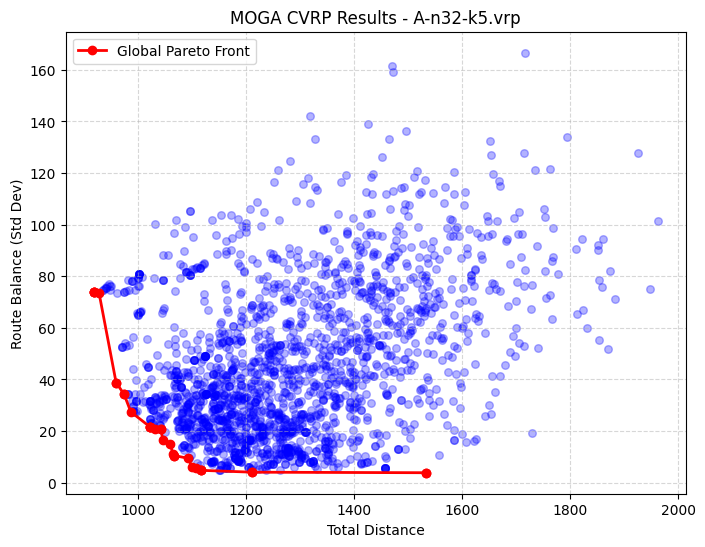

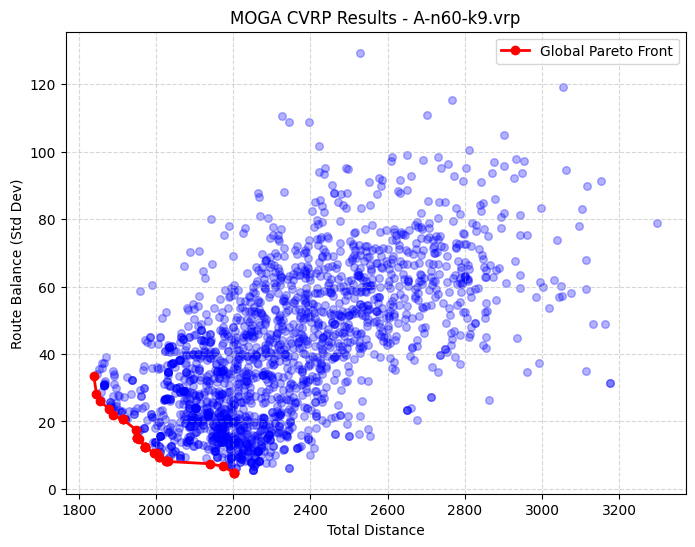

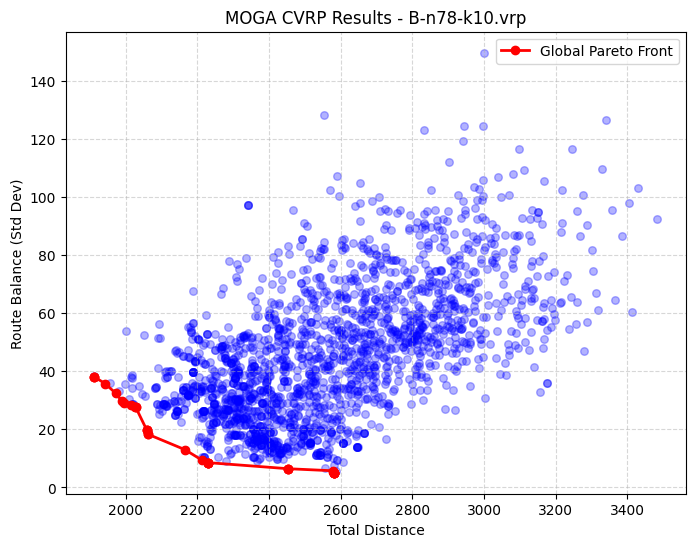

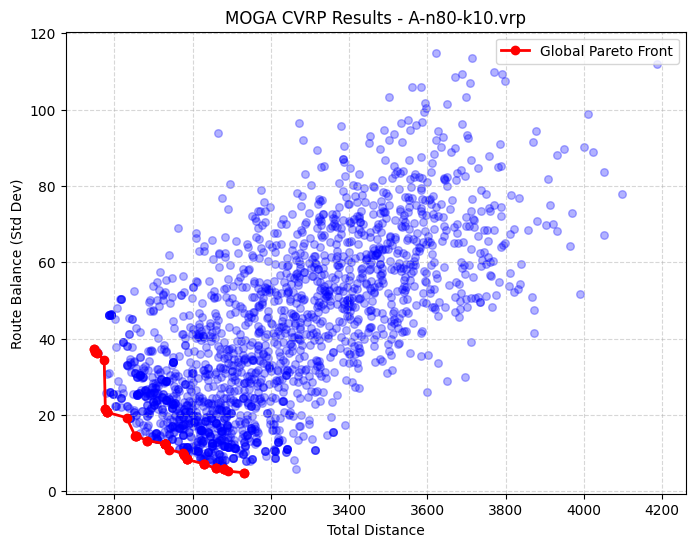

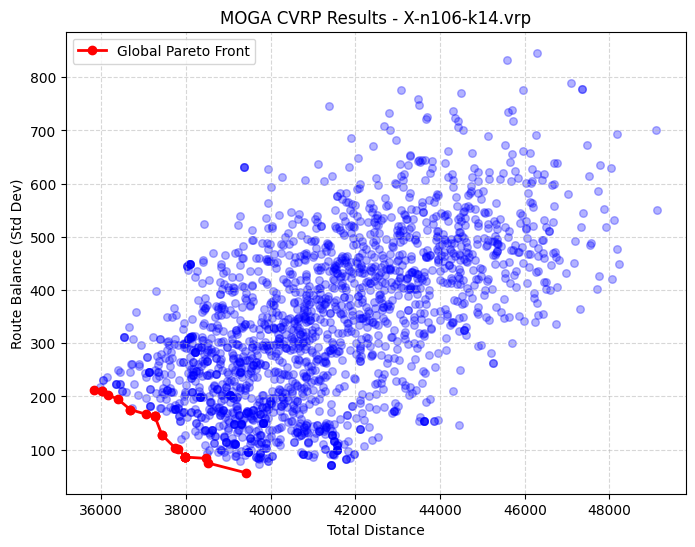

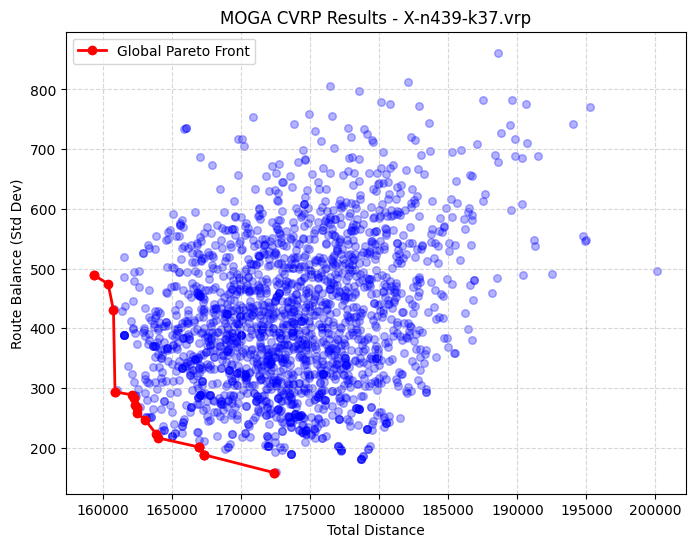

In [37]:
plot_all_results(moga_results, title_prefix="MOGA CVRP Results")

# NSGA 2 Implementation

In [38]:
class Solution:
    def __init__(self, x):
        self.x = x
        self.objectives = None
        self.rank = None
        self.crowding_distance = None

class NSGA2:
    def __init__(
        self,
        pop_size: int,
        crossover_rate: float,
        mutation_rate: float,
        customer_coords: List[Tuple[float, float]],
        depot_coords: Tuple[float, float],
        demands: List[float],
        capacity: float,
        max_vehicles: int,
        seed: int = 0,
    ):
        self.pop_size = pop_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.customer_coords = customer_coords
        self.depot_coords = depot_coords
        self.demands = demands
        assert self.demands[0] == 0, "Demands must include depot at index 0 with demand 0"

        self.capacity = capacity
        self.max_vehicles = max_vehicles
        self.seed = seed
        self.population_history = []
        self.distance_matrix = self._build_distance_matrix()

        random.seed(seed)
        np.random.seed(seed)

    def create_individual(self) -> List[int]:
        indiv = list(range(1, len(self.customer_coords) + 1))
        random.shuffle(indiv)
        return indiv
    
    def _build_distance_matrix(self) -> np.ndarray:
        all_coords = [self.depot_coords] + list(self.customer_coords)
        n = len(all_coords)
        D = np.zeros((n, n), dtype=float)
        for i in range(n):
            xi, yi = all_coords[i]
            for j in range(n):
                xj, yj = all_coords[j]
                D[i, j] = math.hypot(xi - xj, yi - yj)
        return D
    
    def initialize_population(self) -> List[Solution]:
        return [Solution(self.create_individual()) for _ in range(self.pop_size)]
    

    def split_routes(self, permutation: List[int]) -> List[List[int]]:
        """
        Greedy split with HARD vehicle limit:
        - First split greedily by capacity
        - Then enforce max_vehicles by merging routes until within limit
        - Merging ignores capacity constraint (hard limit).
        """
        routes = []
        current_route = []
        current_load = 0

        # Initial greedy split
        for cust in permutation:
            demand = self.demands[cust]
            if current_load + demand > self.capacity:
                if current_route:
                    routes.append(current_route)
                current_route = [cust]
                current_load = demand
            else:
                current_route.append(cust)
                current_load += demand

        if current_route:
            routes.append(current_route)

        # HARD CONSTRAINT: enforce max_vehicles
        while len(routes) > self.max_vehicles:
            # Precompute loads
            loads = [sum(self.demands[c] for c in r) for r in routes]

            best_idx1, best_idx2 = -1, -1
            best_combined = float("inf")

            # Find two routes with smallest combined load
            for i in range(len(routes)):
                for j in range(i + 1, len(routes)):
                    combined = loads[i] + loads[j]
                    if combined < best_combined:
                        best_combined = combined
                        best_idx1, best_idx2 = i, j

            if best_idx1 == -1:  # fallback
                best_idx1, best_idx2 = 0, 1

            # Ensure removal in correct order
            if best_idx1 > best_idx2:
                best_idx1, best_idx2 = best_idx2, best_idx1

            r1, r2 = routes[best_idx1], routes[best_idx2]
            merged = r1 + r2

            # Remove both and insert merged
            routes.pop(best_idx2)
            routes.pop(best_idx1)
            routes.append(merged)

        return routes

    
    def evalute_objectives(self, population):
        for solution in population:
            solution.objectives = np.array([
                self.objective_total_distance(solution.x),
                self.objective_route_balance(solution.x)], dtype=float)


    def dominates(self, p, q):
        return all(p_obj <= q_obj for p_obj, q_obj in zip(p.objectives, q.objectives)) and \
            any(p_obj < q_obj for p_obj, q_obj in zip(p.objectives, q.objectives))
    
    def non_dominated_sort(self, population: List[Solution]):
        for p in population:
            p.domination_count = 0
            p.dominated_solutions = []
            for q in population:
                if self.dominates(p, q):
                    p.dominated_solutions.append(q)
                elif self.dominates(q, p):
                    p.domination_count += 1
            if p.domination_count == 0:
                p.rank = 1
        front = 1
        while True:
            current_front = [p for p in population if p.rank == front]
            if not current_front:
                break
            for p in current_front:
                for q in p.dominated_solutions:
                    q.domination_count -= 1
                    if q.domination_count == 0:
                        q.rank = front + 1
            front += 1


    def calculate_crowding_distance(self, population):
        for p in population:
            p.crowding_distance = 0
        
        for obj in range(num_objectives := 2):
            population.sort(key=lambda sol: sol.objectives[obj])
            population[0].crowding_distance = population[-1].crowding_distance = float('inf')
            obj_range = population[-1].objectives[obj] - population[0].objectives[obj]
            if obj_range == 0:
                continue
            for i in range(1, len(population) - 1):
                population[i].crowding_distance += (population[i + 1].objectives[obj] - population[i - 1].objectives[obj]) / obj_range


    def tournament_selection(self, population):
        a, b = random.sample(population, 2,)
        if a.rank < b.rank or (a.rank == b.rank and a.crowding_distance > b.crowding_distance):
            return a
        return b
    
    
    def crossover(self, parent1: List[int], parent2: List[int]) -> List[int]:
        size = len(parent1)
        if random.random() > self.crossover_rate:
            return parent1.copy()

        a, b = sorted(random.sample(range(size), 2))
        child = [None] * size
        # copy slice from parent1
        child[a:b+1] = parent1[a:b+1]
        # fill remaining from parent2 in order
        p2_idx = 0
        for i in range(size):
            if child[i] is None:
                while parent2[p2_idx] in child:
                    p2_idx += 1
                child[i] = parent2[p2_idx]
                p2_idx += 1
        return child
    
    
    def mutation(self, individual: List[int]) -> List[int]:
        if random.random() < self.mutation_rate:
            i, j = random.sample(range(len(individual)), 2)
            individual[i], individual[j] = individual[j], individual[i]
        return individual
    
    def create_offspring(self, population):
        offspring = []
        while len(offspring) < self.pop_size:
            p1 = self.tournament_selection(population)
            p2 = self.tournament_selection(population)
            child_x = self.crossover(p1.x, p2.x)
            child_x = self.mutation(child_x)
            offspring.append(Solution(child_x))
        return offspring
    
    def select_next_generation(self, population, offspring):
        combined = population + offspring
        self.non_dominated_sort(combined)
        self.calculate_crowding_distance(combined)
        combined.sort(key=lambda sol: (sol.rank, -sol.crowding_distance))
        return combined[:self.pop_size]
    
    def route_distance(self, route):
        dist = self.distance_matrix[0, route[0]]  # depot to first
        for i in range(len(route) - 1):
            dist += self.distance_matrix[route[i], route[i + 1]]
        dist += self.distance_matrix[route[-1], 0]  # last to depot
        return dist
    
    def objective_total_distance(self, individual: List[int]) -> float:
        routes = self.split_routes(individual)
        total_distance = sum(self.route_distance(r) for r in routes)
        return total_distance
    
    def objective_route_balance(self, individual: List[int]) -> float:
        routes = self.split_routes(individual)
        if len(routes) == 0:
            return float('inf')
        route_lengths = [self.route_distance(r) for r in routes]
        return np.std(route_lengths)
    
    def run(self, generations: int = 500):
        population = self.initialize_population()
        self.evalute_objectives(population)
        for gen in range(generations):
            self.evalute_objectives(population)
            self.non_dominated_sort(population)
            self.calculate_crowding_distance(population)
            self.population_history.append(deepcopy(population))

            offspring = self.create_offspring(population)
            self.evalute_objectives(offspring)
            population = self.select_next_generation(population, offspring)
        
        self.evalute_objectives(population)
        self.non_dominated_sort(population)
        fitness_values = np.array([sol.objectives for sol in population])
        return population, fitness_values

    


## NSGA2 Experimentation

In [39]:
def run_single_nsga2(
    depot_coords, customer_coords, demands, capacity,
    pop_size=100, generations=500, max_vehicles=5, seed=0,
    crossover_rate=0.7, mutation_rate=0.2,
):
    start_time = time.time()
    nsga2 = NSGA2(
        pop_size=pop_size,
        crossover_rate=crossover_rate,
        mutation_rate=mutation_rate,
        customer_coords=customer_coords,
        depot_coords=depot_coords,
        demands=demands,
        capacity=capacity,
        max_vehicles=max_vehicles,
        seed=seed,
    )
    
    solutions, fitness_values = nsga2.run(generations=generations)
    
    # Extract Pareto front (solutions with rank 1)
    pareto_sols = [s for s in solutions if s.rank == 1]
    pareto_fits = np.array([s.objectives for s in pareto_sols])
    
    end_time = time.time()
    elapsed = end_time - start_time
    
    # Output solutions (optional)
    for i, (sol, fit) in enumerate(zip(pareto_sols, pareto_fits)):
        print(f"\nSolution {i+1} | Fitness = {fit}")
        routes = nsga2.split_routes(sol.x)
        for j, r in enumerate(routes):
            print(f"  Route {j+1}: [0, {' -> '.join(map(str, r))}, 0]")

    return solutions, pareto_fits, elapsed

In [40]:
results_nsga2, nsga_wall_clock = run_experiments_multiple_files(file_configs, run_fn=run_single_nsga2, runs=20, n_jobs=5)


=== Running file: A-n32-k5.vrp with 20 runs ===
Instance: 31 customers, Capacity: 100, Max Vehicles: 5
Run 1/20 finished in 48.79 seconds
Run 2/20 finished in 51.86 seconds
Run 3/20 finished in 45.13 seconds
Run 4/20 finished in 42.51 seconds
Run 5/20 finished in 47.72 seconds
Run 6/20 finished in 43.42 seconds
Run 7/20 finished in 46.25 seconds
Run 8/20 finished in 42.58 seconds
Run 9/20 finished in 42.59 seconds
Run 10/20 finished in 46.06 seconds
Run 11/20 finished in 50.81 seconds
Run 12/20 finished in 40.25 seconds
Run 13/20 finished in 46.91 seconds
Run 14/20 finished in 45.80 seconds
Run 15/20 finished in 39.66 seconds
Run 16/20 finished in 44.75 seconds
Run 17/20 finished in 54.23 seconds
Run 18/20 finished in 51.08 seconds
Run 19/20 finished in 41.14 seconds
Run 20/20 finished in 45.58 seconds

=== Running file: A-n60-k9.vrp with 20 runs ===
Instance: 59 customers, Capacity: 100, Max Vehicles: 9
Run 1/20 finished in 49.89 seconds
Run 2/20 finished in 47.08 seconds
Run 3/20 fi

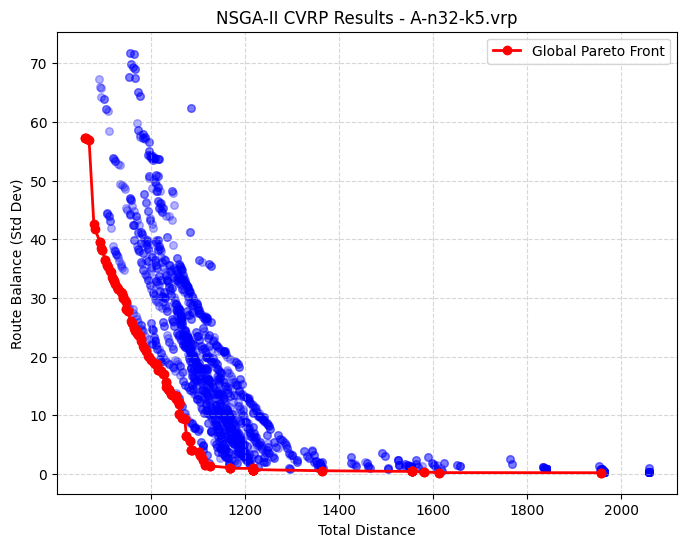

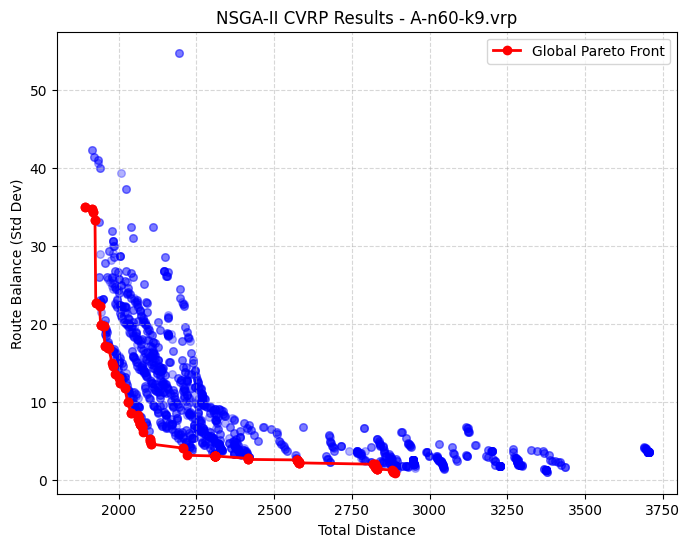

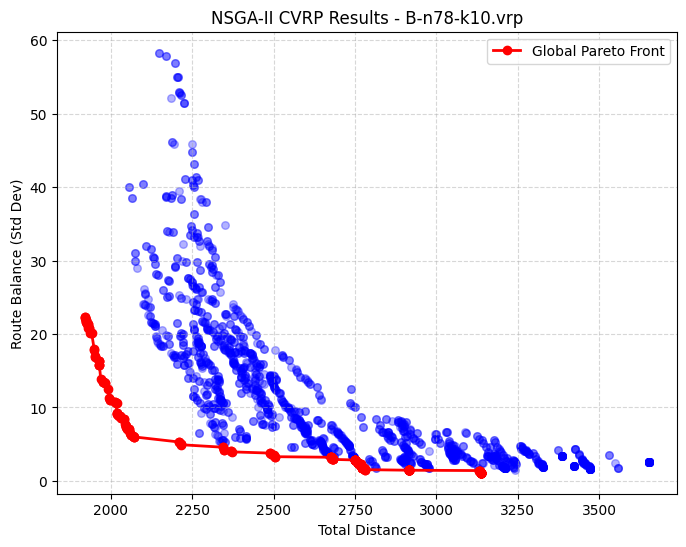

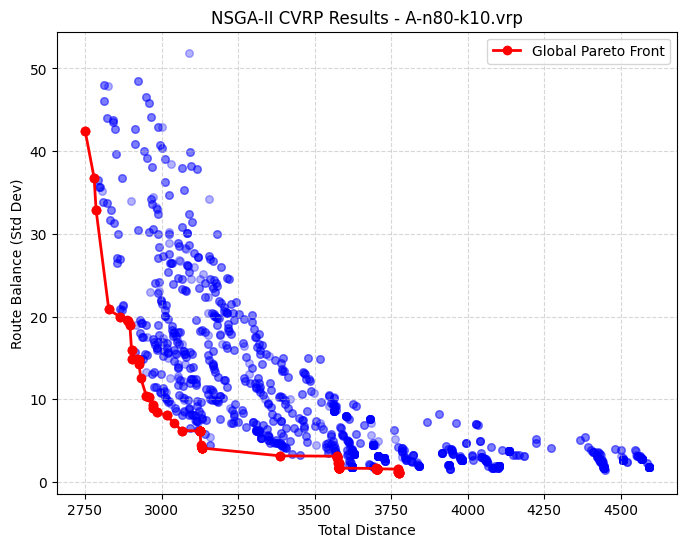

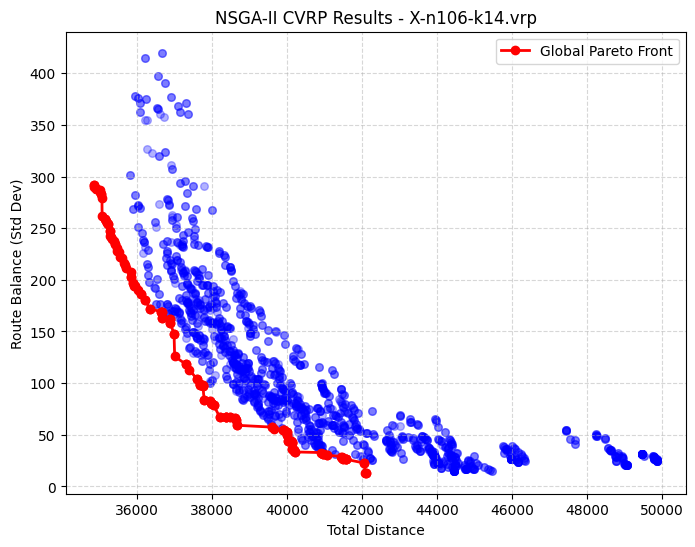

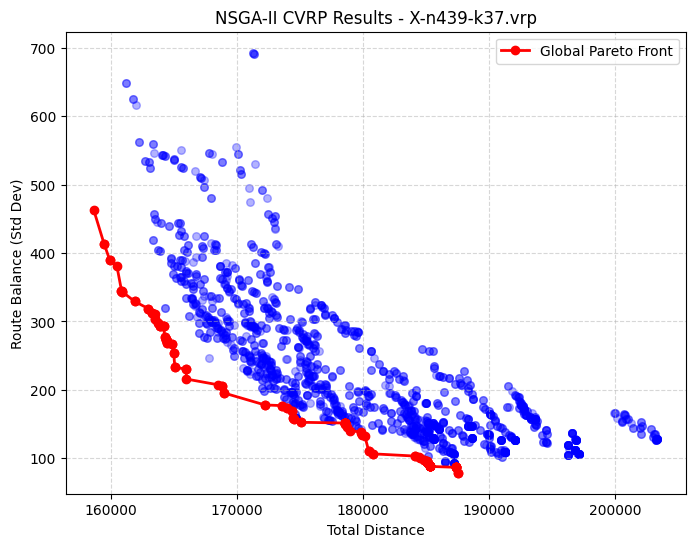

In [41]:
plot_all_results(results_nsga2, title_prefix="NSGA-II CVRP Results")

In [42]:
def summarize_results(all_results, algo_names=None, print_summary=True):
    summary_rows = []
    if algo_names is None:
        algo_names = list(all_results.keys())

    per_algo_dfs = dict()
    for algo_name in algo_names:
        results = all_results[algo_name]
        algo_rows = []
        for scenario, data in results.items():
            all_fronts = data['all_fronts']
            times = data["times"]
            all_points = np.vstack(all_fronts)
            distances = all_points[:, 0]
            balances = all_points[:, 1]
            res = dict(
                Algorithm=algo_name,
                Scenario=scenario,
                Best_Distance=float(np.min(distances)),
                Worst_Distance=float(np.max(distances)),
                Mean_Distance=float(np.mean(distances)),
                Best_Balance=float(np.min(balances)),
                Worst_Balance=float(np.max(balances)),
                Mean_Balance=float(np.mean(balances)),
                Min_Time_s=float(np.min(times)),
                Max_Time_s=float(np.max(times)),
                Mean_Time_s=float(np.mean(times))
            )
            summary_rows.append(res)
            algo_rows.append(res)

        df_algo = pd.DataFrame(algo_rows)
        df_algo.index = df_algo.index + 1
        per_algo_dfs[algo_name] = df_algo
        if print_summary:
            print(f"\n--- Summary Table of VRP Scenarios ({algo_name}) ---")
            print(df_algo.round(2))

    df_all = pd.DataFrame(summary_rows)
    df_all.index = df_all.index + 1
    return df_all, per_algo_dfs

In [43]:
def summarize_wall_clock(wall_clocks):
    df = pd.DataFrame([
        {"Algorithm": algo, "Wall Clock (s)": wall_clocks[algo]}
        for algo in wall_clocks
    ])
    print("\n--- Wall Clock Comparison ---")
    print(df.round(2))
    return df

In [44]:
all_results = dict(MOGA=moga_results, NSGA2=results_nsga2)
wall_clocks = dict(MOGA=moga_wall_clock, NSGA2=nsga_wall_clock)

# Wall clock comparison
summarize_wall_clock(wall_clocks)

# Summaries (prints MOGA and NSGA2)
df_all, per_algo = summarize_results(all_results)

# Direct access if needed
moga_df = per_algo["MOGA"]
nsga2_df = per_algo["NSGA2"]

print("\n--- Combined Summary (All Algorithms) ---")
print(df_all.round(2))


--- Wall Clock Comparison ---
  Algorithm  Wall Clock (s)
0      MOGA       2753.4800
1     NSGA2       1698.8500

--- Summary Table of VRP Scenarios (MOGA) ---
  Algorithm        Scenario  Best_Distance  Worst_Distance  Mean_Distance  \
1      MOGA    A-n32-k5.vrp       918.6500       1961.5000      1277.8000   
2      MOGA    A-n60-k9.vrp      1839.2900       3299.1900      2325.1900   
3      MOGA   B-n78-k10.vrp      1910.9100       3483.6400      2555.6800   
4      MOGA   A-n80-k10.vrp      2747.4600       4188.2500      3211.6300   
5      MOGA  X-n106-k14.vrp     35828.5600      49132.7400     41241.1500   
6      MOGA  X-n439-k37.vrp    159336.9500     200142.6900    173558.8500   

   Best_Balance  Worst_Balance  Mean_Balance  Min_Time_s  Max_Time_s  \
1        3.8800       166.6000       44.6100     98.6100    103.9700   
2        4.7900       129.3700       40.0000    101.9600    105.6800   
3        5.0800       149.6700       44.7900    103.9200    107.5700   
4        4

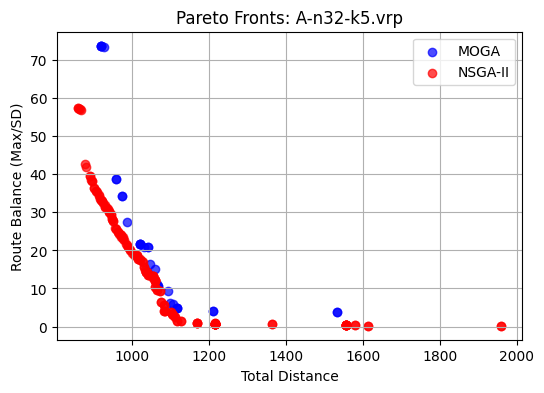

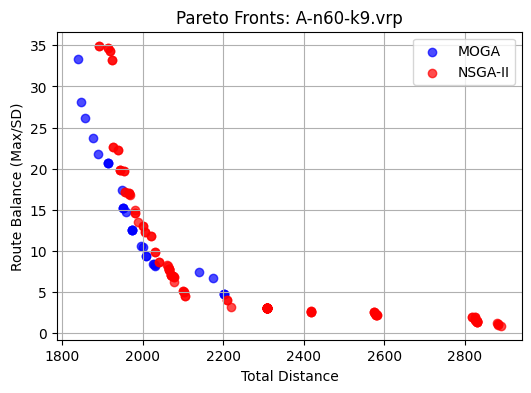

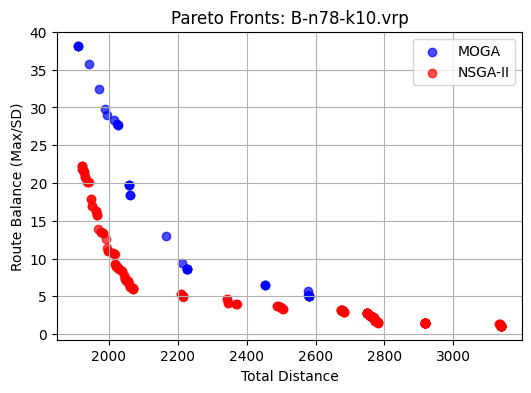

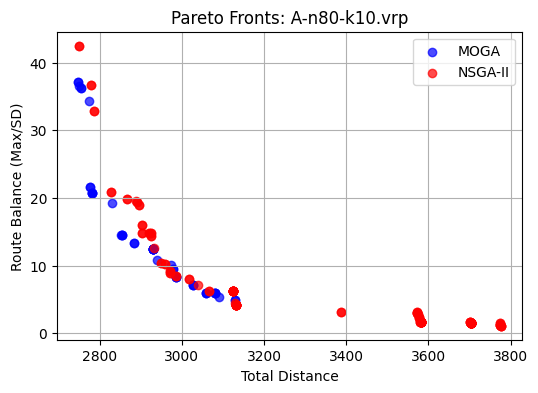

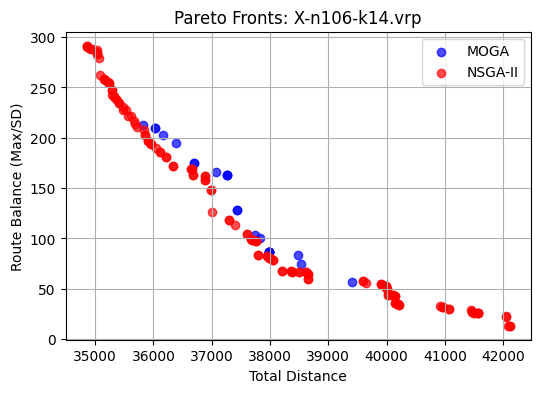

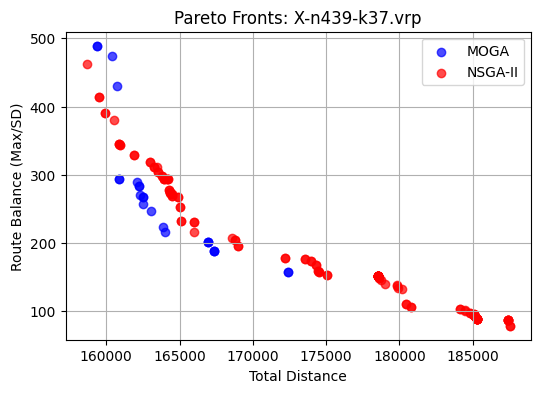

,Dataset,MOGA_GD,MOGA_Spread,MOGA_AvgTime,NSGA_GD,NSGA_Spread,NSGA_AvgTime,Best_Algorithm
0,A-n32-k5.vrp,17.6373,1.1108,101.9439,0.0000,1.1564,45.8550,NSGA-II
1,A-n60-k9.vrp,9.1011,1.0243,104.1831,4.5993,1.1859,49.4183,NSGA-II
2,B-n78-k10.vrp,40.6074,1.1140,105.8093,0.0000,1.2086,53.8694,NSGA-II
3,A-n80-k10.vrp,1.4533,1.1127,106.3938,4.4829,1.2331,63.5462,MOGA
4,X-n106-k14.vrp,35.7318,0.9933,108.5005,5.4458,1.0634,66.1575,NSGA-II
5,X-n439-k37.vrp,63.1982,1.0836,157.5593,370.0874,1.1627,136.3766,MOGA


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Metrics ----------------

def generational_distance(obtained, reference):
    obtained = np.array(obtained)
    reference = np.array(reference)
    distances = []
    for sol in obtained:
        d = np.min(np.linalg.norm(reference - sol, axis=1))
        distances.append(d)
    return np.sqrt(np.mean(np.square(distances)))

def spread_metric(front):
    front = np.array(front)
    if len(front) < 2:
        return 0.0

  
    front = front[np.argsort(front[:, 0])]

  
    distances = np.linalg.norm(np.diff(front, axis=0), axis=1)
    d_mean = np.mean(distances)

  
    d_f = np.linalg.norm(front[0] - front[-1])
    d_l = d_f  

    delta = (d_f + d_l + np.sum(np.abs(distances - d_mean))) / (d_f + d_l + (len(distances) * d_mean))
    return delta

# ---------------- Computing Metrics ----------------

rows = []

for ds in moga_results.keys():
    combined_front = np.vstack([moga_results[ds]['global_front'], results_nsga2[ds]['global_front']])
    is_efficient = np.ones(len(combined_front), dtype=bool)
    for i, p in enumerate(combined_front):
        if is_efficient[i]:
            dominates = np.all(combined_front <= p, axis=1) & np.any(combined_front < p, axis=1)
            dominates[i] = False
            if np.any(dominates):
                is_efficient[i] = False
    reference_front = combined_front[is_efficient]

    # ---------------- MOGA Metrics ----------------
    moga_front = np.array(moga_results[ds]['global_front'])
    gd_moga = generational_distance(moga_front, reference_front)
    spread_moga = spread_metric(moga_front)
    avg_time_moga = np.mean(moga_results[ds]['times'])

    # ---------------- NSGA-II Metrics ----------------
    nsga_front = np.array(results_nsga2[ds]['global_front'])
    gd_nsga = generational_distance(nsga_front, reference_front)
    spread_nsga = spread_metric(nsga_front)
    avg_time_nsga = np.mean(results_nsga2[ds]['times'])

  
    if gd_moga < gd_nsga:
        best_algo = 'MOGA'
    elif gd_nsga < gd_moga:
        best_algo = 'NSGA-II'
    else:
        best_algo = 'Tie'

    rows.append({
        'Dataset': ds,
        'MOGA_GD': gd_moga,
        'MOGA_Spread': spread_moga,
        'MOGA_AvgTime': avg_time_moga,
        'NSGA_GD': gd_nsga,
        'NSGA_Spread': spread_nsga,
        'NSGA_AvgTime': avg_time_nsga,
        'Best_Algorithm': best_algo
    })

    # ---------------- Plot Pareto Fronts ----------------
    plt.figure(figsize=(6,4))
    plt.scatter(moga_front[:,0], moga_front[:,1], c='blue', label='MOGA', alpha=0.7)
    plt.scatter(nsga_front[:,0], nsga_front[:,1], c='red', label='NSGA-II', alpha=0.7)
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance (Max/SD)')
    plt.title(f'Pareto Fronts: {ds}')
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------- Summary Table ----------------
df_metrics = pd.DataFrame(rows)
pd.set_option('display.float_format', '{:.4f}'.format)
df_metrics
